# DARTS

## 0. Paper

### Info
* Title: DARTS: Differentiable Architecture Search
* Author: Hanxiao Liu
* Task: Neural Architecture Search
* Link: https://arxiv.org/abs/1806.09055


### Features
* Dataset: CIFAR-10

### Reference
* https://github.com/quark0/darts
* https://github.com/dragen1860/DARTS-PyTorch
* https://github.com/khanrc/pt.darts


## 1. Setting

In [1]:
import os
import sys
import copy
import time
import itertools
from glob import glob
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from graphviz import Digraph


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchsummary import torchsummary

In [2]:
CONFIG = {
    'unrolled': False,
    'auxiliary': True,
    'auxiliary_weight': 0.4,
    'drop_path_prob': 0.2,
    'init_C': 16,
    'n_layers': 8,
    'lr': 0.025,
    'momentum': 0.9,
    'weight_decay': 3e-4,
    'grad_clip': 5,
    'batch_size': 64,
    'search_epoch_size': 10,
    'epoch_size': 200,
}

## 2. Data

In [3]:
def create_loader(n_valid):
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2439, 0.2616)),
    ])

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2439, 0.2616)),
    ])

    train_dataset = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=train_transform)
    test_dataset = torchvision.datasets.CIFAR10('/data', train=True, download=True, transform=test_transform)
    train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [50000-n_valid, n_valid])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)
    return train_loader, valid_loader, test_loader

In [4]:
train_loader, valid_loader, test_loader = create_loader(n_valid=5000)
x, y = next(iter(train_loader))
x.size(), y.size()


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


(torch.Size([64, 3, 32, 32]), torch.Size([64]))

## 3. Model

### Genotypes

In [5]:
Genotype = namedtuple('Genotype', 'normal normal_concat reduce reduce_concat')
DARTS = Genotype(
    normal=[('sep_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 0), ('sep_conv_3x3', 1), ('sep_conv_3x3', 1), ('skip_connect', 0), ('skip_connect', 0), ('dil_conv_3x3', 2)], 
    normal_concat=[2, 3, 4, 5], 
    reduce=[('max_pool_3x3', 0), ('max_pool_3x3', 1), ('skip_connect', 2), ('max_pool_3x3', 1), ('max_pool_3x3', 0), ('skip_connect', 2), ('skip_connect', 2), ('max_pool_3x3', 1)], 
    reduce_concat=[2, 3, 4, 5])

In [6]:
PRIMITIVES = [
    'none', 'max_pool_3x3', 'avg_pool_3x3', 'skip_connect',
    'sep_conv_3x3', 'sep_conv_5x5', 'dil_conv_3x3', 'dil_conv_5x5'
]

### Operations

In [7]:
class Zero(nn.Module):
    def __init__(self, stride):
        super(Zero, self).__init__()
        self.stride = stride
    
    def forward(self, x):
        if self.stride == 2:
            x = x[:,:,::self.stride, ::self.stride]
        return x.mul(0.)


class FactorizedReduce(nn.Module):
    def __init__(self, C_in, C_out, affine=True):
        super(FactorizedReduce, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(C_in, C_out//2, kernel_size=1, stride=2, bias=False)
        self.conv2 = nn.Conv2d(C_in, C_out//2, kernel_size=1, stride=2, bias=False)
        self.bn = nn.BatchNorm2d(C_out, affine=affine)

    def forward(self, x):
        x = self.relu(x)
        x1 = self.conv1(x)
        x2 = self.conv2(x[:,:,1:,1:])
        x = torch.cat([x1, x2], dim=1)
        x = self.bn(x)
        return x


class SepConv(nn.Module):
    def __init__(self, in_C, out_C, kernel_size, stride, padding, affine=True):
        super(SepConv, self).__init__()
        self.ops = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_C, in_C, kernel_size=kernel_size, stride=stride, padding=padding, groups=in_C, bias=False),
            nn.Conv2d(in_C, in_C, kernel_size=1, bias=False),
            nn.BatchNorm2d(in_C, affine=affine),
            nn.Conv2d(in_C, in_C, kernel_size=kernel_size, stride=1, padding=padding, groups=in_C, bias=False),
            nn.Conv2d(in_C, out_C, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_C, affine=affine)
        )
    
    def forward(self, x):
        return self.ops(x)


class DilConv(nn.Module):
    def __init__(self, in_C, out_C, kernel_size, stride, padding, affine=True):
        super(DilConv, self).__init__()
        self.ops = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_C, in_C, kernel_size=kernel_size, stride=stride, padding=padding, dilation=2, groups=in_C, bias=False),
            nn.Conv2d(in_C, out_C, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_C, affine=affine)
        )
    
    def forward(self, x):
        return self.ops(x)


class ReLUConvBN(nn.Module):
    def __init__(self, in_C, out_C, kernel_size, stride, padding, affine=True):
        super(ReLUConvBN, self).__init__()
        self.ops = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(in_C, out_C, kernel_size=kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_C, affine=affine)
        )
    
    def forward(self, x):
        return self.ops(x)

In [8]:
OPS = {
    'none': lambda C, stride, affine: Zero(stride),
    'avg_pool_3x3': lambda C, stride, affine: nn.AvgPool2d(kernel_size=3, stride=stride, padding=1, count_include_pad=False),
    'max_pool_3x3': lambda C, stride, affine: nn.MaxPool2d(kernel_size=3, stride=stride, padding=1),
    'skip_connect': lambda C, stride, affine: nn.Identity() if stride == 1 else FactorizedReduce(C, C, affine),
    'sep_conv_3x3': lambda C, stride, affine: SepConv(C, C, 3, stride, 1, affine),
    'sep_conv_5x5': lambda C, stride, affine: SepConv(C, C, 5, stride, 2, affine),
    'sep_conv_7_7': lambda C, stride, affine: SepConv(C, C, 7, stride, 3, affine),
    'dil_conv_3x3': lambda C, stride, affine: DilConv(C, C, 3, stride, 2, affine),
    'dil_conv_5x5': lambda C, stride, affine: DilConv(C, C, 5, stride, 4, affine)
}

### Search Network

In [9]:
class MixedOp(nn.Module):
    def __init__(self, C, stride):
        super(MixedOp, self).__init__()
        self.ops = nn.ModuleList()

        for primitive in PRIMITIVES:
            op = OPS[primitive](C, stride, False)
            if 'pool' in primitive:
                op = nn.Sequential(
                    op,
                    nn.BatchNorm2d(C, affine=False)
                )
            self.ops.append(op)
    
    def forward(self, x, weights):
        out = sum([w * l(x) for w, l in zip(weights, self.ops)])
        return out


class SearchCell(nn.Module):
    def __init__(self, steps, multiplier, prev_prev_C, prev_C, curr_C, reduction, prev_reduction):
        super(SearchCell, self).__init__()
        self.steps = steps
        self.multiplier = multiplier
        self.reduction = reduction

        if prev_reduction:
            self.prep0 = FactorizedReduce(prev_prev_C, curr_C, affine=False)
        else:
            self.prep0 = ReLUConvBN(prev_prev_C, curr_C, kernel_size=1, stride=1, padding=0, affine=False)
        self.prep1 = ReLUConvBN(prev_C, curr_C, kernel_size=1, stride=1, padding=0, affine=False)

        self.layers = nn.ModuleList()
        for i in range(steps):
            for j in range(2+i):
                stride = 2 if reduction and j < 2 else 1
                op = MixedOp(curr_C, stride)
                self.layers.append(op)
    
    def forward(self, s0, s1, weights):
        s0 = self.prep0(s0)
        s1 = self.prep1(s1)

        states = [s0, s1]
        offset = 0
        for i in range(self.steps):
            s = sum([self.layers[offset + j](h, weights[offset + j])for j, h in enumerate(states)])
            offset += len(states)
            states.append(s)
            
        return torch.cat(states[-self.multiplier:], dim=1)

In [10]:
class SearchNetwork(nn.Module):
    def __init__(self, C, n_classes, n_layers, criterion, device, steps=4, multiplier=4, stem_multiplier=3):
        super(SearchNetwork, self).__init__()
        self.C = C
        self.n_classes = n_classes
        self.n_layers = n_layers
        self.criterion = criterion
        self.device = device
        self.steps = steps
        self.multiplier = multiplier

        curr_C = C * stem_multiplier
        self.stem = nn.Sequential(
            nn.Conv2d(3, curr_C, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(curr_C)
        )

        prev_prev_C, prev_C, curr_C = curr_C, curr_C, C
        self.cells = nn.ModuleList()
        prev_reduction = False
        for i in range(n_layers):
            if i in [n_layers//3, 2*n_layers//3]:
                curr_C *= 2
                reduction = True
            else:
                reduction = False
            
            cell = SearchCell(steps, multiplier, prev_prev_C, prev_C, curr_C, reduction, prev_reduction)
            prev_reduction = reduction
            self.cells.append(cell)
            prev_prev_C, prev_C = prev_C, multiplier * curr_C

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(prev_C, n_classes)
        )

        k = sum(1 for i in range(steps) for j in range(2 + i))
        num_ops = len(PRIMITIVES)
        self.alpha_normal = nn.Parameter(torch.randn(k, num_ops) * 1e-3)
        self.alpha_reduce = nn.Parameter(torch.randn(k, num_ops) * 1e-3)
    

    def arch_parameters(self):
        return [self.alpha_normal, self.alpha_reduce]
    

    def new(self):
        new_model = Network(self.C, self.n_classes, self.n_layers, self.criterion, self.device).to(self.device)
        for x, y in zip(new_model.arch_parameters(), self.arch_parameters()):
            x.data.copy_(y.data)
        return new_model
    

    def loss(self, inputs, targets):
        logits = self(inputs)
        return self.criterion(logits, targets)
    

    def forward(self, x):
        s0 = s1 = self.stem(x)

        for i, cell in enumerate(self.cells):
            if cell.reduction:
                weights = F.softmax(self.alpha_reduce, dim=-1)
            else:
                weights = F.softmax(self.alpha_normal, dim=-1)
            s0, s1 = s1, cell(s0, s1, weights)
        
        logits = self.classifier(s1)
        return logits

    
    def genotype(self):
        
        def _parse(weights):
            gene = []
            n = 2
            start = 0
            for i in range(self.steps): # for each node
                end = start + n
                W = weights[start:end].copy() # [2, 8], [3, 8], ...
                edges = sorted(range(i + 2), # i+2 is the number of connection for node i
                            key=lambda x: -max(W[x][k] # by descending order
                                               for k in range(len(W[x])) # get strongest ops
                                               if k != PRIMITIVES.index('none'))
                               )[:2] # only has two inputs
                for j in edges: # for every input nodes j of current node i
                    k_best = None
                    for k in range(len(W[j])): # get strongest ops for current input j->i
                        if k != PRIMITIVES.index('none'):
                            if k_best is None or W[j][k] > W[j][k_best]:
                                k_best = k
                    gene.append((PRIMITIVES[k_best], j)) # save ops and input node
                start = end
                n += 1
            return gene

        gene_normal = _parse(F.softmax(self.alpha_normal, dim=-1).data.cpu().numpy())
        gene_reduce = _parse(F.softmax(self.alpha_reduce, dim=-1).data.cpu().numpy())

        concat = range(2 + self.steps - self.multiplier, self.steps + 2)
        genotype = Genotype(
            normal=gene_normal, normal_concat=concat,
            reduce=gene_reduce, reduce_concat=concat
        )

        return genotype

### Architecture

In [11]:
def concat(xs):
    return torch.cat([x.view(-1) for x in xs])

In [12]:
class Architecture(object):

    def __init__(self, model, lr=3e-4, momentum=0.9, weight_decay=1e-3):
        self.model = model
        self.momentum = momentum
        self.weight_decay = weight_decay
        self.optimizer = torch.optim.Adam(self.model.arch_parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=weight_decay)


    def compute_unrolled_model(self, inputs, targets, eta, optimizer):
        loss = self.model.loss(inputs, targets)
        theta = concat(self.model.parameters()).detach() # theta: torch.Size([1930618])
        try:
            # fetch momentum data from theta optimizer
            moment = concat(optimizer.state[v]['momentum_buffer'] for v in self.model.parameters())
            moment.mul_(self.momentum)
        except:
            moment = torch.zeros_like(theta)

        dtheta = concat(torch.autograd.grad(loss, self.model.parameters())).data
        theta = theta.sub(eta, moment + dtheta + self.weight_decay * theta)
        unrolled_model = self.construct_model_from_theta(theta) # construct a new model
        return unrolled_model


    def step(self, train_inputs, train_targets, valid_inputs, valid_targets, eta, optimizer, unrolled):
        self.optimizer.zero_grad()
        if unrolled:
            self.backward_step_unrolled(train_inputs, train_targets, valid_inputs, valid_targets, eta, optimizer)
        else:
            self.backward_step(valid_inputs, valid_targets)
        self.optimizer.step()


    def backward_step(self, valid_inputs, valid_targets):
        loss = self.model.loss(valid_inputs, valid_targets)
        loss.backward()

    def backward_step_unrolled(self, train_inputs, train_targets, valid_inputs, valid_targets, eta, optimizer):
        unrolled_model = self.compute_unrolled_model(train_inputs, train_targets, eta, optimizer)
        unrolled_loss = unrolled_model.loss(valid_inputs, valid_targets)
        unrolled_loss.backward()
        # grad(L(w', a), a), part of Eq. 6
        dalpha = [v.grad for v in unrolled_model.arch_parameters()]
        vector = [v.grad.data for v in unrolled_model.parameters()]
        implicit_grads = self.hessian_vector_product(vector, train_inputs, train_targets)

        for g, ig in zip(dalpha, implicit_grads):
            g.data.sub_(eta, ig.data)

        for v, g in zip(self.model.arch_parameters(), dalpha):
            if v.grad is None:
                v.grad = g.data
            else:
                v.grad.data.copy_(g.data)

    def construct_model_from_theta(self, theta):
        model_new = self.model.new()
        model_dict = self.model.state_dict()

        params, offset = {}, 0
        for k, v in self.model.named_parameters():
            v_length = v.numel()
            # restore theta[] value to original shape
            params[k] = theta[offset: offset + v_length].view(v.size())
            offset += v_length

        assert offset == len(theta)
        model_dict.update(params)
        model_new.load_state_dict(model_dict)
        return model_new.cuda()

    def hessian_vector_product(self, vector, inputs, targets, r=1e-2):
        R = r / concat(vector).norm()

        for p, v in zip(self.model.parameters(), vector):
            # w+ = w + R * v
            p.data.add_(R, v)
        loss = self.model.loss(inputs, targets)
        # gradient with respect to alpha
        grads_p = torch.autograd.grad(loss, self.model.arch_parameters())


        for p, v in zip(self.model.parameters(), vector):
            # w- = (w+R*v) - 2R*v
            p.data.sub_(2 * R, v)
        loss = self.model.loss(inputs, targets)
        grads_n = torch.autograd.grad(loss, self.model.arch_parameters())

        for p, v in zip(self.model.parameters(), vector):
            # w = (w+R*v) - 2R*v + R*v
            p.data.add_(R, v)

        h = [(x - y).div_(2 * R) for x, y in zip(grads_p, grads_n)]
        # h len: 2 h0 torch.Size([14, 8])
        # print('h len:', len(h), 'h0', h[0].shape)
        return h

### Network

In [ ]:
def drop_path(x, drop_prob):
    if drop_prob > 0:
        keep_prob = 1 - drop_prob
        mask = x.bernoulli(keep_prob)
        x.div_(keep_prob)
        x.mul_(mask)
    return x
    

class Cell(nn.Module):
    def __init__(self, genotype, prev_prev_C, prev_C, C, reduction, prev_reduction):
        super(Cell, self).__init__()
        if prev_reduction:
            self.prep0 = FactorizedReduce(prev_prev_C, C)
        else:
            self.prep0 = ReLUConvBN(prev_prev_C, C, kernel_size=1, stride=1, padding=0)
        self.prep1 = ReLUConvBN(prev_C, C, kernel_size=1, stride=1, padding=0)

        if reduction:
            op_names, indices = zip(*genotype.reduce)
            concat = genotype.reduce_concat
        else:
            op_names, indices = zip(*genotype.normal)
            concat = genotype.normal_concat
        
        self.steps = len(op_names) // 2
        self.indices = indices
        self.concat = concat
        self.multiplier = len(concat)
        self.ops = nn.ModuleList()
        for name, idx in zip(op_names, indices):
            stride = 2 if reduction and idx < 2 else 1
            op = OPS[name](C, stride, True)
            self.ops.append(op)
    

    def forward(self, s0, s1, drop_prob):
        s0 = self.prep0(s0)
        s1 = self.prep1(s1)
        states = [s0, s1]

        for i in range(self.steps):
            h1 = states[self.indices[2 * i]]
            h2 = states[self.indices[2 * i + 1]]
            op1 = self.ops[2 * i]
            op2 = self.ops[2 * i + 1]
            h1 = op1(h1)
            h2 = op2(h2)

            if self.training and drop_prob > 0:
                if not isinstance(op1, nn.Identity):
                    h1 = drop_path(h1, drop_prob)
                if not isinstance(op2, nn.Identity):
                    h2 = drop_path(h2, drop_prob)
            
            s = h1 + h2
            states.append(s)
        
        return torch.cat([states[i] for i in self.concat], dim=1)


class AuxiliaryHead(nn.Module):
    def __init__(self, aux_C, n_classes):
        super(AuxiliaryHead, self).__init__()
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(2),
            nn.Conv2d(aux_C, 128, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 768, kernel_size=2, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(768),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(768, n_classes)
        )
    
    def forward(self, x):
        return self.layers(x)


class Network(nn.Module):
    def __init__(self, C, n_classes, n_layers, auxiliary, genotype, stem_multiplier=3):
        super(Network, self).__init__()
        self.n_layers = n_layers
        self.auxiliary = auxiliary

        curr_C = stem_multiplier * C
        self.stem = nn.Sequential(
            nn.Conv2d(3, curr_C, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(curr_C)
        )

        prev_prev_C, prev_C, curr_C = curr_C, curr_C, C
        self.cells = nn.ModuleList()
        prev_reduction = False

        for i in range(n_layers):
            if i in [n_layers//3, 2*n_layers //3]:
                curr_C *= 2
                reduction = True
            else:
                reduction = False
            
            cell = Cell(genotype, prev_prev_C, prev_C, curr_C, reduction, prev_reduction)
            prev_reduction = reduction
            self.cells.append(cell)
            prev_prev_C, prev_C = prev_C, cell.multiplier * curr_C

            if i == 2 * n_layers // 3:
                aux_C = prev_C
        
        if auxiliary:
            self.aux_head = AuxiliaryHead(aux_C, n_classes)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(prev_C, n_classes)
        )
    

    def forward(self, x):
        aux_logits = None
        s0 = s1 = self.stem(x)
        for i, cell in enumerate(self.cells):
            s0, s1 = s1, cell(s0, s1, self.drop_path_prob)
            if i == 2 * self.n_layers // 3:
                if self.auxiliary and self.training:
                    aux_logits = self.aux_head(s1)
        logits = self.classifier(s1)
        return logits, aux_logits

## 4. Experiment

### Train Search

In [13]:
def plot(genotype, filename):
    g = Digraph(
        format='png',
        edge_attr=dict(fontsize='20', fontname="times"),
        node_attr=dict(style='filled', shape='rect', align='center', fontsize='20', height='0.5', width='0.5',
                       penwidth='2', fontname="times"),
        engine='dot')
    g.body.extend(['rankdir=LR'])

    g.node("c_{k-2}", fillcolor='darkseagreen2')
    g.node("c_{k-1}", fillcolor='darkseagreen2')
    assert len(genotype) % 2 == 0
    steps = len(genotype) // 2

    for i in range(steps):
        g.node(str(i), fillcolor='lightblue')

    for i in range(steps):
        for k in [2 * i, 2 * i + 1]:
            op, j = genotype[k]
            if j == 0:
                u = "c_{k-2}"
            elif j == 1:
                u = "c_{k-1}"
            else:
                u = str(j - 2)
            v = str(i)
            g.edge(u, v, label=op, fillcolor="gray")

    g.node("c_{k}", fillcolor='palegoldenrod')
    for i in range(steps):
        g.edge(str(i), "c_{k}", fillcolor="gray")

    g.render(filename, view=True)

In [14]:
class AverageMeter(object):
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.sum = 0
        self.count = 0
        self.avg = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = f'{self.name:10s} {self.avg:.3f}'
        return fmtstr


class ProgressMeter(object):
    def __init__(self, meters, loader_length, prefix=""):
        self.meters = [AverageMeter(i) for i in meters]
        self.loader_length = loader_length
        self.prefix = prefix
    
    def reset(self):
        for m in self.meters:
            m.reset()
    
    def update(self, values, n=1):
        for m, v in zip(self.meters, values):
            m.update(v, n)
            self.__setattr__(m.name, m.avg)

    def display(self, batch_idx, postfix=""):
        batch_info = f'[{batch_idx+1:03d}/{self.loader_length:03d}]'
        msg = [self.prefix + ' ' + batch_info]
        msg += [str(meter) for meter in self.meters]
        msg = ' | '.join(msg)

        sys.stdout.write('\r')
        sys.stdout.write(msg + postfix)
        sys.stdout.flush()


def accuracy(logits, targets):
    _, pred = logits.max(1)
    acc = pred.eq(targets).float().mean().item()
    return acc

In [15]:
class SearchTrainer(object):
    def __init__(self, model, architecture, criterion, optimizer, scheduler, device):
        self.model = model
        self.architecture = architecture
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device


    def train(self, train_loader, valid_loader, epoch):
        progress = ProgressMeter(["train_loss", "train_acc"], len(train_loader), prefix=f'EPOCH {epoch:03d}')
        self.model.train()
        valid_iter = iter(valid_loader)
        lr = self.scheduler.get_last_lr()[0]

        start_time = time.time()
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            valid_inputs, valid_targets = next(valid_iter)
            valid_inputs, valid_targets = valid_inputs.to(self.device), valid_targets.to(self.device)

            self.architecture.step(inputs, targets, valid_inputs, valid_targets, lr, self.optimizer, CONFIG['unrolled'])
            logits = self.model(inputs)
            loss = self.criterion(logits, targets)

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), CONFIG['grad_clip'])
            self.optimizer.step()

            acc = accuracy(logits, targets)
            loss = loss.item()
            progress.update([loss, acc], n=inputs.size(0))
            if idx % 5 == 0:
                progress.display(idx)

        self.scheduler.step()
        finish_time = time.time()
        epoch_time = finish_time - start_time
        progress.display(idx, f' | {epoch_time:.0f}s' + '\n')

    
    def validate(self, val_loader, epoch):
        len_valid = 100
        progress = ProgressMeter(["val_loss", "val_acc"], len_valid, prefix=f'VALID {epoch:03d}')
        self.model.eval()

        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                logits = self.model(inputs)
                loss = self.criterion(logits, targets)
                acc = accuracy(logits, targets)
                progress.update([loss, acc], n=inputs.size(0))
                progress.display(idx)
                if idx == len_valid - 1:
                    break
        
        genotype = self.model.genotype()
        plot(genotype.normal, f'results/{epoch:02d}_normal')
        plot(genotype.reduce, f'results/{epoch:02d}_reduce')
        
        ckpt = {
            'model_state_dict': self.model.state_dict(),
            'genotype': self.model.genotype()
        }
        torch.save(ckpt, 'search_ckpt.pt')
        progress.display(idx, '\n')

In [16]:
train_loader, valid_loader, test_loader = create_loader(n_valid=25000)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model = SearchNetwork(CONFIG['init_C'], 10, CONFIG['n_layers'], criterion, device).to(device)
optimizer = torch.optim.SGD(model.parameters(), CONFIG['lr'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CONFIG['epoch_size'], eta_min=1e-3)
architecture = Architecture(model)

Files already downloaded and verified
Files already downloaded and verified


In [17]:
trainer = SearchTrainer(model, architecture, criterion, optimizer, scheduler, device)

In [18]:
for ep in range(CONFIG['search_epoch_size']):
    print('-' * 65)
    trainer.train(train_loader, valid_loader, ep)
    trainer.validate(valid_loader, ep)

-----------------------------------------------------------------
EPOCH 000 [391/391] | train_loss 1.573 | train_acc  0.425 | 604s
VALID 000 [100/100] | val_loss   1.393 | val_acc    0.493
-----------------------------------------------------------------
EPOCH 001 [391/391] | train_loss 1.121 | train_acc  0.602 | 604s
VALID 001 [100/100] | val_loss   1.068 | val_acc    0.631
-----------------------------------------------------------------
EPOCH 002 [391/391] | train_loss 0.909 | train_acc  0.683 | 604s
VALID 002 [100/100] | val_loss   0.913 | val_acc    0.689
-----------------------------------------------------------------
EPOCH 003 [391/391] | train_loss 0.774 | train_acc  0.728 | 604s
VALID 003 [100/100] | val_loss   0.846 | val_acc    0.704
-----------------------------------------------------------------
EPOCH 004 [391/391] | train_loss 0.698 | train_acc  0.759 | 603s
VALID 004 [100/100] | val_loss   0.762 | val_acc    0.740
-------------------------------------------------------

Normal Cell


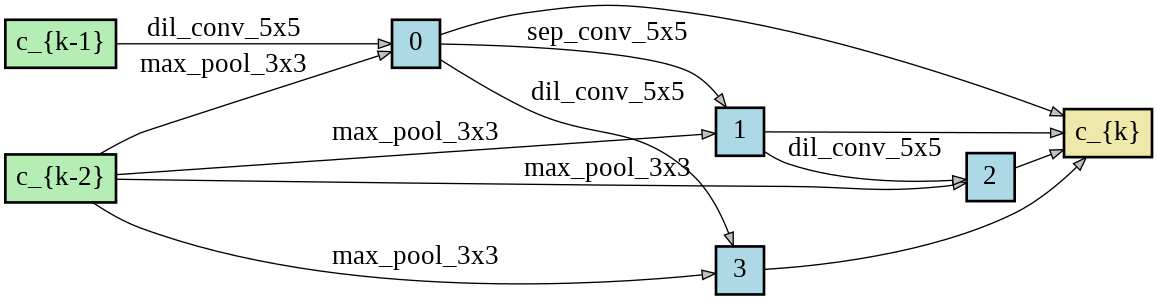

Reduce Cell


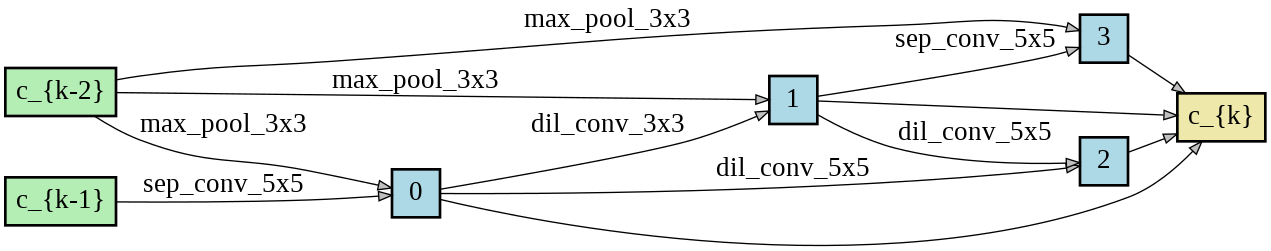

In [21]:
print('Normal Cell')
display(Image.open(f'results/{ep:02d}_normal.png'))
print('Reduce Cell')
display(Image.open(f'results/{ep:02d}_reduce.png'))

### Train CIFAR

In [23]:
class Trainer(object):
    def __init__(self, model, criterion, optimizer, scheduler, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        self.best_epoch, self.best_acc = 0, 0
        

    def train(self, train_loader, epoch):
        progress = ProgressMeter(["train_loss", "train_acc"], len(train_loader), prefix=f'EPOCH {epoch:03d}')
        self.model.train()
        self.model.drop_path_prob = CONFIG['drop_path_prob'] * epoch / CONFIG['epoch_size']

        start_time = time.time()
        for idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            logits, aux_logits = self.model(inputs)
            loss = self.criterion(logits, targets)
            if CONFIG['auxiliary']:
                aux_loss = self.criterion(aux_logits, targets)
                loss += CONFIG['auxiliary_weight'] * aux_loss

            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), CONFIG['grad_clip'])
            self.optimizer.step()

            acc = accuracy(logits, targets)
            loss = loss.item()
            progress.update([loss, acc], n=inputs.size(0))
            if idx % 20 == 0:
                progress.display(idx+1)

        self.scheduler: self.scheduler.step()
        finish_time = time.time()
        epoch_time = finish_time - start_time
        progress.display(idx, f' | {epoch_time:.0f}s' + '\n')

    
    def validate(self, val_loader, epoch):
        progress = ProgressMeter(["val_loss", "val_acc"], len(val_loader), prefix=f'VALID {epoch:03d}')
        self.model.eval()

        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(val_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                logits, _ = self.model(inputs)
                loss = self.criterion(logits, targets)
                acc = accuracy(logits, targets)
                progress.update([loss, acc], n=inputs.size(0))

            if progress.val_acc > self.best_acc:
                self.best_epoch = epoch
                self.best_acc = progress.val_acc
                ckpt = {
                    'best_epoch': self.best_epoch,
                    'best_acc': self.best_acc,
                    'model_state_dict': model.state_dict()
                }
                torch.save(ckpt, 'ckpt.pt')

            
            progress.display(idx, '\n')

    
    def test(self, test_loader):
        progress = ProgressMeter(["test_loss", "test_acc"], len(test_loader), prefix=f'TEST')
        ckpt = torch.load('ckpt.pt')
        self.model.load_state_dict(ckpt['model_state_dict'])
        self.model.eval()

        with torch.no_grad():
            for idx, (inputs, targets) in enumerate(test_loader):
                inputs, targets = inputs.to(device), targets.to(device)
                logits, _ = self.model(inputs)
                loss = self.criterion(logits, targets)
                acc = accuracy(logits, targets)
                progress.update([loss, acc], n=inputs.size(0))

            progress.display(idx, '\n')

In [24]:
train_loader, valid_loader, test_loader = create_loader(n_valid=5000)
ckpt = torch.load('search_ckpt.pt')
genotype = ckpt['genotype']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss().to(device)
model = Network(CONFIG['init_C'], 10, CONFIG['n_layers'], CONFIG['auxiliary'], genotype).to(device)
optimizer = torch.optim.SGD(model.parameters(), CONFIG['lr'], momentum=CONFIG['momentum'], weight_decay=CONFIG['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CONFIG['epoch_size'], eta_min=1e-3)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
trainer = Trainer(model, criterion, optimizer, scheduler, device)
torchsummary.summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 48, 32, 32]           1,296
       BatchNorm2d-2           [-1, 48, 32, 32]              96
              ReLU-3           [-1, 48, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]             768
       BatchNorm2d-5           [-1, 16, 32, 32]              32
        ReLUConvBN-6           [-1, 16, 32, 32]               0
              ReLU-7           [-1, 48, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]             768
       BatchNorm2d-9           [-1, 16, 32, 32]              32
       ReLUConvBN-10           [-1, 16, 32, 32]               0
        MaxPool2d-11           [-1, 16, 32, 32]               0
             ReLU-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]             400
           Conv2d-14           [-1, 16,

In [26]:
for ep in range(CONFIG['epoch_size']):
    print('-' * 65)
    trainer.train(train_loader, ep)
    trainer.validate(valid_loader, ep)

-----------------------------------------------------------------
EPOCH 000 [704/704] | train_loss 1.907 | train_acc  0.514 | 60s
VALID 000 [079/079] | val_loss   1.120 | val_acc    0.621
-----------------------------------------------------------------
EPOCH 001 [704/704] | train_loss 1.267 | train_acc  0.688 | 63s
VALID 001 [079/079] | val_loss   0.881 | val_acc    0.698
-----------------------------------------------------------------
EPOCH 002 [704/704] | train_loss 1.062 | train_acc  0.741 | 63s
VALID 002 [079/079] | val_loss   0.907 | val_acc    0.677
-----------------------------------------------------------------
EPOCH 003 [704/704] | train_loss 0.949 | train_acc  0.769 | 63s
VALID 003 [079/079] | val_loss   0.793 | val_acc    0.733
-----------------------------------------------------------------
EPOCH 004 [704/704] | train_loss 0.876 | train_acc  0.787 | 63s
VALID 004 [079/079] | val_loss   0.659 | val_acc    0.772
------------------------------------------------------------

In [27]:
trainer.test(test_loader)

TEST [782/782] | test_loss  0.209 | test_acc   0.926
